## TESS light curve fit for an eclipsing binary
Example of using the EBLM class with [lmfit](https://lmfit.github.io/lmfit-py/) in pycheops.models to fit a TESS light curve of the eclipsing binary system EBLM J0113+31.

In [1]:
%pylab inline
from astroquery.mast import Observations
from astropy.table import Table, Column
from pycheops import models
from pycheops.funcs import transit_width
from pycheops.ld import stagger_power2_interpolator
from uncertainties import UFloat, ufloat
from emcee import EnsembleSampler
import celerite
from celerite import terms
from scipy.optimize import minimize

Populating the interactive namespace from numpy and matplotlib


#### Target information
From Gómez Maqueo Chew et al., [2014A&A...572A..50G](https://ui.adsabs.harvard.edu/abs/2014A%26A...572A..50G/abstract).

In [2]:
TIC = 400048097 
T0 = 2456023.26988 - 2457000  # Time of mid-transit, BJD-2457000
P = 14.2769001
pwidth = 0.026  # Width of primary eclipse
phsec = 0.532   # Phase of secondary eclipse
swidth = 0.014  # Width of secondary eclipse
Teff = 5961     # Primary star effective temperature
FeH  = -0.14    # Primary star [Fe/H]
logg = 4.09     # Primary star log g 
ecc = 0.3098    # Orbital eccentricity
omdeg = 278.85  # Longitude of periastron in degrees
incl  = 89.084  # Orbital incliation in degrees
r1    = 0.0532  # R_1/a
r2    = 0.0081  # R_2/a
arsun = 25.811  # semi-major axis in solar units

#### Download TESS data

In [3]:
flux_column = 'PDCSAP_FLUX'
# flux_column = 'SAP_FLUX'

quality_bitmask=1130799  # "default": cadences with severe quality issues will be ignored
# quality_bitmask=1664431 #  more conservative choice of flags to ignore - this is known to remove good data.

tjd = []
flux = []
import warnings
from astroquery.mast.core import NoResultsWarning
warnings.simplefilter('ignore',NoResultsWarning)
for obs in Observations.query_criteria(filters=["TESS"],target_name=TIC):
    obslist = Observations.get_product_list(obs['obsid'])
    m=Observations.download_products(obslist[obslist['description'] == "Light curves"])
    if m is not None:
        data = Table.read(m['Local Path'][0])
        iok = ( ((data['QUALITY'] & quality_bitmask) == 0) &
                isfinite(data[flux_column])).nonzero()
        data = data[iok]
        tjd=np.append(tjd,array(data['TIME']))  
        flx=data[flux_column] 
        flux=np.append(flux,flx/median(flx))


INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000400048097-0161-s/tess2019279210107-s0017-0000000400048097-0161-s_lc.fits with expected size 1831680. [astroquery.query]


#### Divide-out GP fit to variations between eclipses

We use Gaussian Process regression with [celerite](https://celerite.readthedocs.io/en/stable/) to model the variation between the eclipses and then interpolate/infer the variation across the eclipses.

 The light-curve in binned into uniform time steps of 1 hour since we are only interested in modelling slow variations in flux.  

Initial log likelihood: 2852.9926716157593


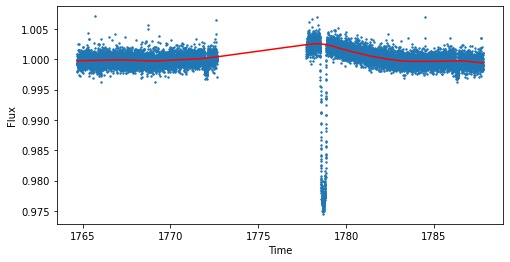

In [4]:
phase = ((((tjd - (T0))/P % 1)+0.25) % 1) - 0.25
mask_out = ((abs(phase) > pwidth/2) & (abs(phase-phsec)>swidth/2)).nonzero()
mask_in = ((abs(phase) <= pwidth/2) | (abs(phase-phsec)<swidth/2)).nonzero()

tjd_mo = tjd[mask_out]
flux_mo = flux[mask_out]

n_bin = int(max(tjd)-min(tjd))*24
n_in_bin,bin_edges = np.histogram(tjd_mo,bins=n_bin)
bin_indices = np.digitize(tjd_mo,bin_edges)
t_bin = np.zeros(n_bin)
f_bin = np.zeros(n_bin)
e_bin = np.zeros(n_bin)
min_in_bin = 8
for i,n in enumerate(n_in_bin):
    if n > min_in_bin:
        t_bin[i] = mean(tjd_mo[bin_indices == i+1])
        f_bin[i] = median(flux_mo[bin_indices == i+1])
        e_bin[i] = 1.25*mean(abs(flux_mo[bin_indices == i+1] - f_bin[i]))/sqrt(n)

mask_not_empty = (e_bin > 0)
t_bin = t_bin[mask_not_empty]
f_bin = f_bin[mask_not_empty]
e_bin = e_bin[mask_not_empty]

Q = 1.0
w0 = 1.0
S0 = np.var(f_bin) / (w0 * Q)
bounds = dict(log_S0=(-25, 15), log_Q=(-15, 15), log_omega0=(-15, 25))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)
gp = celerite.GP(kernel, mean=np.mean(f_bin))
gp.compute(t_bin, yerr=e_bin)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp.log_likelihood(f_bin)))
def neg_log_like(params, f_bin, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(f_bin)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(f_bin, gp))
gp.set_parameter_vector(r.x)
pred_mean = gp.predict(f_bin, tjd,return_cov=False,return_var=False)

fig1, ax1 = subplots(figsize=(8,4))
ax1.scatter(tjd,flux,s=2)
ax1.plot(tjd, pred_mean, color='r')
ax1.set_xlabel('Time')
ax1.set_ylabel('Flux')

flux = flux/pred_mean

#### Construct model

 Parameters such as "P", "W", "D", etc. have the same name and definition in different models so we use the  "prefix" and "expr" features of lmfit to set them to a single value. 

In [5]:
M = models.EBLMModel()
pars = M.make_params()

T_mid = T0 + round((np.median(tjd)-T0)/P)*P
pars.add('T_0', value=T_mid, min=T_mid-0.25*P,max=T_mid+0.25*P)
pars.add('P', value=P, vary=False)
k = r2/r1
pars.add('D', value=k**2, min=0.01,max=0.1)
b = np.cos(np.radians(incl))/r1
pars.add('b', value=b, min = 0,max = 1)
pars.add('W', value=transit_width(r1,k,b), min = 0.01,max = 0.04)
pars.add('f_s', value =np.sqrt(ecc)*np.sin(np.radians(omdeg)))
pars.add('f_c', value =np.sqrt(ecc)*np.cos(np.radians(omdeg)))
pars.add('L', value = 0.002, min=1e-6,max=1e-2)
    
LimbDarkeningInterpolator = stagger_power2_interpolator(passband='TESS')
c2, a2, h_1, h_2 = LimbDarkeningInterpolator(Teff,4.0,0.0)
pars.add('h_1', value = h_1, vary=True)
pars.add('h_2', value = h_2, vary=False)
print('h_1 = {:0.3f}'.format(h_1))
print('h_2 = {:0.3f}'.format(h_2))

for p in pars:
    if pars[p].vary: print(pars[p])

h_1 = 0.801
h_2 = 0.431
<Parameter 'T_0', value=1778.7115993000361, bounds=[1775.1423742750362:1782.280824325036]>
<Parameter 'D', value=0.023181779637062583, bounds=[0.01:0.1]>
<Parameter 'W', value=0.018850595252339678, bounds=[0.01:0.04]>
<Parameter 'b', value=0.3004987767924069, bounds=[0:1]>
<Parameter 'L', value=0.002, bounds=[1e-06:0.01]>
<Parameter 'f_c', value=0.08563139934521381, bounds=[-inf:inf]>
<Parameter 'f_s', value=-0.5499702386913137, bounds=[-inf:inf]>
<Parameter 'h_1', value=0.8008997400000001, bounds=[-inf:inf]>


#### Plot initial fit

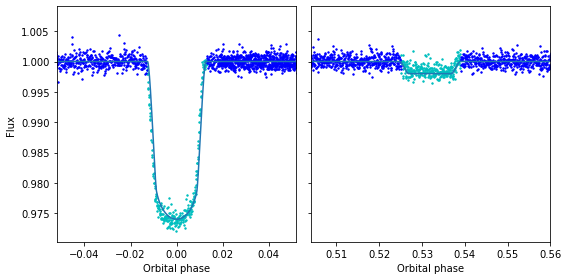

In [6]:
fig2, ax2 = subplots(ncols=2,figsize=(8,4),sharey=True)
ph_plot = linspace(-0.5,1.5,10001)
t_plot = T0 + ph_plot*P
f_plot = M.eval(pars,t=t_plot)
for a in ax2:
    a.scatter(phase[mask_in],flux[mask_in],s=2,c='c')
    a.scatter(phase[mask_out],flux[mask_out],s=2,c='b')
    a.set_xlabel('Orbital phase')
    a.plot(ph_plot,f_plot)

ax2[0].set_ylabel('Flux ')
ax2[0].set_xlim(-2*pwidth,2*pwidth)
ax2[1].set_xlim(phsec-2*swidth,phsec+2*swidth);
fig2.tight_layout();

#### Least-squares fit

In [7]:
result_lm = M.fit(flux,pars,t=tjd)
print(result_lm.fit_report())

[[Model]]
    Model(_eblm_func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 73
    # data points      = 12938
    # variables        = 8
    chi-square         = 0.00985208
    reduced chi-square = 7.6196e-07
    Akaike info crit   = -182254.498
    Bayesian info crit = -182194.755
[[Variables]]
    T_0:  1778.70068 +/- 2.3821e-04 (0.00%) (init = 1778.712)
    P:    14.2769 (fixed)
    D:    0.02377628 +/- 1.6724e-04 (0.70%) (init = 0.02318178)
    W:    0.01892835 +/- 1.9934e-04 (1.05%) (init = 0.0188506)
    b:    0.33323546 +/- 0.01600271 (4.80%) (init = 0.3004988)
    L:    0.00154537 +/- 5.9252e-05 (3.83%) (init = 0.002)
    f_c:  0.08578689 +/- 0.00174667 (2.04%) (init = 0.0856314)
    f_s: -0.55740690 +/- 0.00958669 (1.72%) (init = -0.5499702)
    h_1:  0.81967587 +/- 0.01134100 (1.38%) (init = 0.8008997)
    h_2:  0.4306441 (fixed)
    a_c:  0 (fixed)
    k:    0.15419559 +/- 5.4229e-04 (0.35%) == 'sqrt(D)'
    J:    0.06499610 +/- 0.00252749 (3

#### Plot best fit

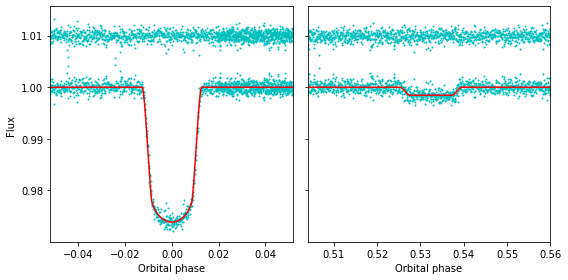

In [8]:
phase = ((((tjd - (result_lm.params['T_0'].value))/P % 1)+0.25) % 1) - 0.25
fig2, ax2 = subplots(ncols=2,figsize=(8,4),sharey=True)
t_plot = result_lm.params['T_0'].value + ph_plot*P
f_plot = M.eval(result_lm.params,t=t_plot)
for a in ax2:
    a.scatter(phase,flux,s=1,c='c')
    a.scatter(phase,result_lm.residual+1.01,s=1,c='c')
    a.set_xlabel('Orbital phase')
    a.plot(ph_plot,f_plot,c='r')

ax2[0].set_ylabel('Flux ')
ax2[0].set_xlim(-2*pwidth,2*pwidth)
ax2[1].set_xlim(phsec-2*swidth,phsec+2*swidth);
fig2.tight_layout();

### Sampling the posterior with emcee
This requires some work to set up a target log-posterior function and to create an initial position for the emcee walkers that does not include invalid parameter values.

Here we use a simple white-noise model with constant standard deviation $\sigma$ (parameterised as "log_sigma") to calculate the likelihood.

#### Target function for Minimizer.emcee
 The user_data feature of lmfit's [Parameter](https://lmfit.github.io/lmfit-py/parameters.html#lmfit.parameter.Parameter) class can be used to set a ufloat values that defines a Gaussian prior on a parameter. 
 
 The first parameter "pos" is a list of trial values for the free parameters. The complete set of parameters must be sent as one of the arguments so that the value of fixed parameters is available to this function. 
 


In [9]:
def log_posterior(pos, model, time, flux,  params, varnames,
        return_fit):

    parcopy = params.copy()
    for i, p in enumerate(varnames):
        v = pos[i]
        if (v < parcopy[p].min) or (v > parcopy[p].max):
            return -np.inf
        parcopy[p].value = v
        
    fit = model.eval(parcopy, t=time)
    if return_fit:
        return fit

    if False in np.isfinite(fit):
        return -np.inf

    lnprior = 0
    for p in parcopy:
        u = parcopy[p].user_data
        if isinstance(u, UFloat):
            lnprior += -0.5*((u.n - parcopy[p].value)/u.s)**2
            
    s2 = np.exp(2*parcopy['log_sigma'].value)
    lnlike = -0.5*(np.sum((flux-fit)**2/s2 + np.log(s2)))
    return lnlike + lnprior

#### Initial walker positions
Start at the best-fit solution and use the error estimates from the least-squares fit to set the size of the random offsets for each parameter used to set up the initial walker positions.

Also, add a Gaussian prior on the orbital period.

In [10]:
nwalkers = 64
nburnin = 512
nsteps = 64
thin = 4

params = result_lm.params
log_rms = np.log(result_lm.residual.std())
params.add('log_sigma', value=log_rms, min=log_rms-2,max=log_rms+2,vary=True)

# Add Gaussian prior on the orbital period
params['P'].user_data=ufloat(8.79936, 0.00003)

varvals = []
varerrs = []
varnames = []
for p in params:
    if params[p].vary:
        varnames.append(p)
        varvals.append(params[p].value)
        if params[p].stderr is None:
            varerrs.append(0.1*(params[p].max-params[p].min))
        else:
            varerrs.append(params[p].stderr)
            
n_varys = len(varvals)
varvals = np.array(varvals)
varerrs = np.array(varerrs)
init_scale = 0.1  # use this fraction of standard error to spread walker positions  
args=(M, tjd, flux,  params, varnames, False)

pos = []
for i in range(nwalkers):
    params_tmp = params.copy()
    lnlike_i = -np.inf
    while lnlike_i == -np.inf:
        pos_i = varvals + varerrs*np.random.randn(n_varys)*init_scale
        lnlike_i = log_posterior(pos_i, *args)
    pos.append(pos_i)

#### Run the sampler

In [16]:
sampler = EnsembleSampler(nwalkers, n_varys, log_posterior,args=args)
print('Running burn-in ...')
pos, _, _ = sampler.run_mcmc(pos, nburnin, store=False, 
                             skip_initial_state_check=True, progress=True)
sampler.reset()
print('Running sampler ...')
state = sampler.run_mcmc(pos, nsteps, thin_by=thin, progress=True)

Running burn-in ...


100%|██████████| 512/512 [05:55<00:00,  1.44it/s]


Running sampler ...


100%|██████████| 256/256 [02:54<00:00,  1.47it/s]


#### Plot parameter v. step number to check for convergence

Only plotting selected parameters here.

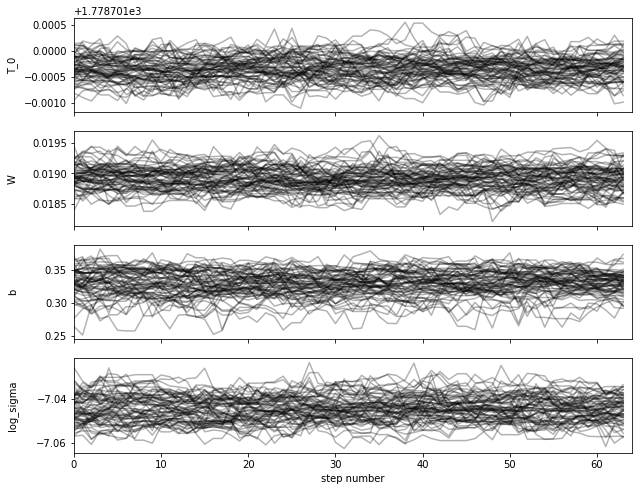

In [17]:
fig, axes = plt.subplots(4, figsize=(10, 8), sharex=True)
samples = sampler.get_chain()
for i,p in enumerate(["T_0", "W", 'b', "log_sigma"]):
    ax = axes[i]
    j = varnames.index(p)
    ax.plot(samples[:, :, j], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(p)
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");

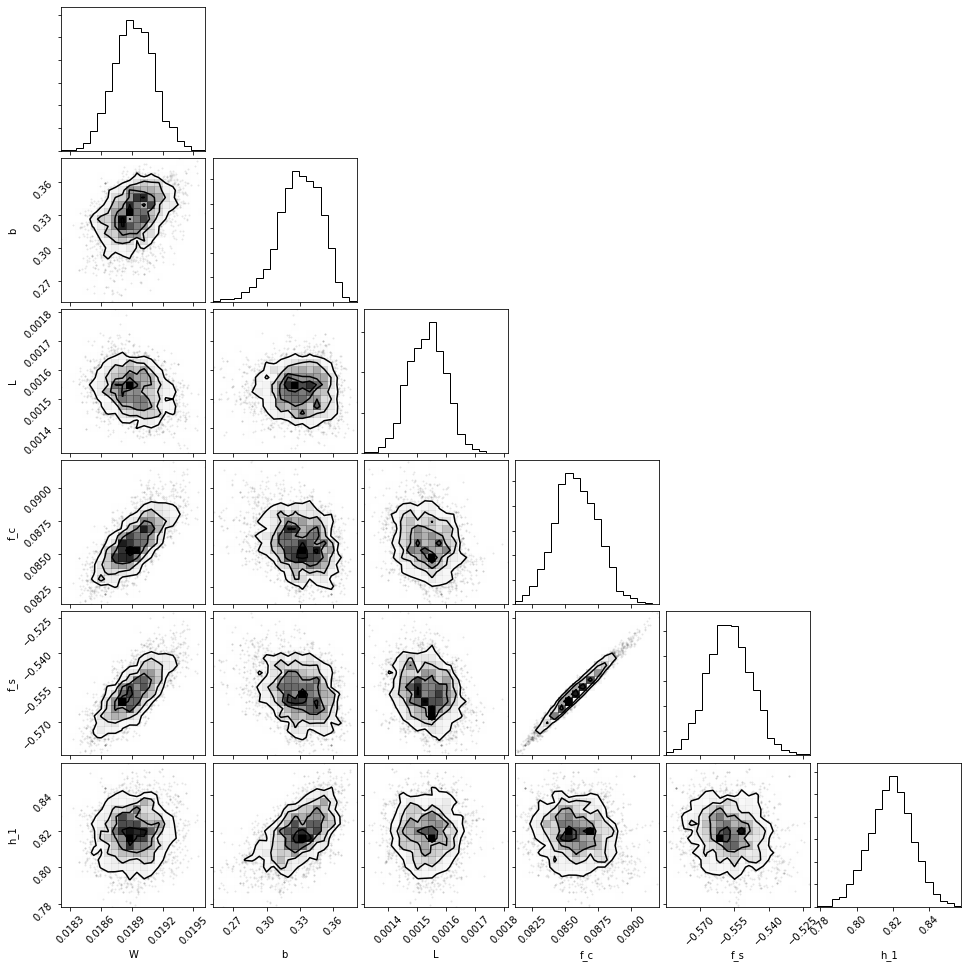

In [18]:
import corner
flat_samples = sampler.get_chain(flat=True)
fig = corner.corner(flat_samples[:,2:8], labels=varnames[2:8]);

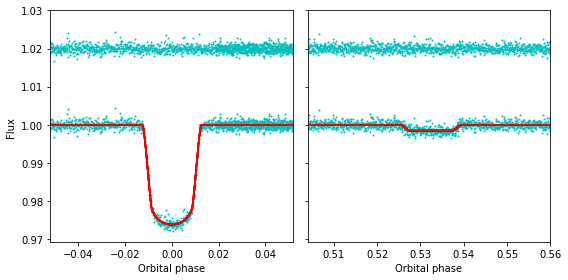

In [19]:
pos = flat_samples[argmax(sampler.flatlnprobability),:]
fit = log_posterior(pos, M, tjd, flux,  params, varnames,
        return_fit=True)
fig3, ax3 = subplots(ncols=2,figsize=(8,4),sharey=True)
f_plot = log_posterior(pos, M, t_plot, flux,  params, varnames,
        return_fit=True)
for a in ax3:
    a.scatter(phase,flux,s=1,c='c')
    a.scatter(phase,flux-fit+1.02,s=1,c='c')
    a.set_xlabel('Orbital phase')
    a.plot(ph_plot,f_plot,c='r')

nsamples = 64
for i in np.linspace(0,nsteps,nsamples,endpoint=False,dtype=np.int):
    pos = flat_samples[i,:]
    f_plot = log_posterior(pos, M, t_plot, flux,  params, varnames,
        return_fit=True)
    ax3[0].plot(ph_plot,f_plot,c='r',alpha=0.1)
    ax3[1].plot(ph_plot,f_plot,c='r',alpha=0.1)

    ax3[0].set_ylabel('Flux ')
ax3[0].set_xlim(-2*pwidth,2*pwidth)
ax3[1].set_xlim(phsec-2*swidth,phsec+2*swidth);
fig3.tight_layout();

&copy; Pierre Maxted, Keele University (2020)